#### Surface Mass Density

In [1]:
# NumCosmo

from numcosmo_py import Nc, Ncm
from numcosmo_py.ccl.nc_ccl import create_nc_obj
import nc_concentration

# CCL

import pyccl as ccl

# Colossus

from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_hernquist
from colossus.halo import mass_so
from colossus.utils import constants

import sys
import numpy as np
import math
import matplotlib.pyplot as plt

Set Cosmology

In [2]:
Omega_c = 0.262
Omega_b = 0.049
Omega_k = 0.0
H0 = 67.66
Tcmb0 = 2.7255
A_s = 2.1e-9
sigma8 = 0.8277
n_s = 0.96
Neff = 0.0
w0 = -1.0
wa = 0.0

In [3]:
# Colossus Cosmology
params=dict(H0 = H0, Om0 = (Omega_c+Omega_b), Ob0 = Omega_b, Tcmb0 = Tcmb0, Neff = Neff, sigma8 = sigma8, ns = n_s, w0=w0, wa=wa)
cosmo_col = cosmology.setCosmology("mycosmo", params)
cosmology.setCurrent(cosmo_col)

# CCL Cosmology
ccl_cosmo = ccl.Cosmology(
    Omega_c=Omega_c,
    Omega_b=Omega_b,
    Neff=Neff,
    h=H0/100.0,
    sigma8=sigma8,
    n_s=n_s,
    Omega_k=Omega_k,
    w0=w0,
    wa=wa,
    T_CMB=Tcmb0,
    m_nu=[0.00, 0.0, 0.0],
    transfer_function="eisenstein_hu",
    matter_power_spectrum="linear",
)

# NumCosmo Cosmology
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())
nc_cosmo = create_nc_obj(ccl_cosmo)
cosmo = nc_cosmo.cosmo

In [4]:
def cmp_double(desc, m1, m2, x1, x2):
    print(
        "%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e"
        % (desc, m1, x1, m2, x2, math.fabs(x1 / x2 - 1.0))
    )

Set parameters

In [5]:
M = 1E12
z = 0.0
mdef = 'vir'
M_col = M * cosmo_col.h
a = 1.0 / (1.0 + z)
R = 1e2

Set c-M models

In [6]:
# NumCosmo
cmr_Duffy08 = Nc.HaloCMDuffy08.new(Nc.HaloMassSummaryMassDef.VIRIAL, 200)
cmr_Duffy08.param_set_by_name("log10MDelta", 12.0)
cmr_Duffy08_nc = cmr_Duffy08.concentration(cosmo, 0.0)

cmr_Klypin11 = Nc.HaloCMKlypin11.new(Nc.HaloMassSummaryMassDef.VIRIAL, 200)
cmr_Klypin11.param_set_by_name("log10MDelta", 12.0)
cmr_Klypin11_nc = cmr_Klypin11.concentration(cosmo, 0.0)

# Colossus
col_d08 = concentration.concentration(M_col, 'vir', 0.0, 'duffy08')
col_k11 = concentration.concentration(M_col, 'vir', 0.0, 'klypin11')

# CCL
d08 = ccl.halos.ConcentrationDuffy08(mass_def = 'vir')
ccl_d08 = d08(ccl_cosmo, M, 1.0)
k11 = ccl.halos.ConcentrationKlypin11(mass_def = 'vir')
ccl_k11 = k11(ccl_cosmo, M, 1.0)

In [7]:
cmp_double("D08", "NumCosmo", "COL", cmr_Duffy08_nc, col_d08)
cmp_double("K11", "NumCosmo", "COL", cmr_Klypin11_nc, col_k11)

print("--------------------------------------------------------------------------------")

cmp_double("D08", "NumCosmo", "CCL", cmr_Duffy08_nc, ccl_d08)
cmp_double("K11", "NumCosmo", "CCL", cmr_Klypin11_nc, ccl_k11)

print("--------------------------------------------------------------------------------")

cmp_double("D08", "COL     ", "CCL", col_d08, ccl_d08)
cmp_double("K11", "COL     ", "CCL", col_k11, ccl_k11)

D08: NumCosmo =       8.57030336317361, COL =       8.57030336317361, CMP:  2.22e-16
K11: NumCosmo =       9.88544748973416, COL =       9.88544748973416, CMP:  2.22e-16
--------------------------------------------------------------------------------
D08: NumCosmo =       8.57030336317361, CCL =       8.57030336317361, CMP:  2.22e-16
K11: NumCosmo =       9.88544748973416, CCL =       9.88544748973416, CMP:  2.22e-16
--------------------------------------------------------------------------------
D08: COL      =       8.57030336317361, CCL =       8.57030336317361, CMP:  0.00e+00
K11: COL      =       9.88544748973416, CCL =       9.88544748973416, CMP:  0.00e+00


Set density profile - Duffy08

In [8]:
# CCL

mdef_ccl = ccl.halos.MassDef(Delta="vir", rho_type = "matter")
d08 = ccl.halos.ConcentrationDuffy08(mass_def = mdef_ccl)
mdef_ccl.concentration = d08
ccl_nfw = ccl.halos.HaloProfileNFW(mass_def=mdef_ccl, concentration=d08, truncated=False, projected_analytic=True, cumul2d_analytic=True)
ccl_ein = ccl.halos.HaloProfileEinasto(mass_def=mdef_ccl, concentration=d08, truncated=False, projected_quad=True, alpha=0.2)
ccl_her = ccl.halos.HaloProfileHernquist(mass_def=mdef_ccl, concentration=d08, truncated=False, projected_analytic=True, cumul2d_analytic=True)

alpha = ccl_ein._get_alpha(ccl_cosmo, M, a)

# Colossus

col_nfw = profile_nfw.NFWProfile(M=M_col, c=col_d08, z=z, mdef="vir")
col_ein = profile_einasto.EinastoProfile(M=M_col, c=col_d08, z=z, mdef="vir", alpha=0.2)
col_her = profile_hernquist.HernquistProfile(M=M_col, c=col_d08, z=z, mdef="vir")

# NumCosmo

nfw = Nc.HaloDensityProfileNFW.new(cmr_Duffy08)
ein = Nc.HaloDensityProfileEinasto.new(cmr_Duffy08)
her = Nc.HaloDensityProfileHernquist.new(cmr_Duffy08)
ein.param_set_by_name("alpha", 0.2)


Comparing NFW, Einasto and Hernquist the Surface Mass Density (D08)

In [9]:
# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity(R * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity(R * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)
col_Sigma_her = col_her.surfaceDensity(R * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)

# NumCosmo
nc_Sigma_nfw = nfw.eval_2d_density(cosmo, R, z)
nc_Sigma_ein = ein.eval_2d_density(cosmo, R, z)
nc_Sigma_her = her.eval_2d_density(cosmo, R, z)

# CCL
ccl_Sigma_nfw = ccl_nfw.projected(ccl_cosmo, R / a, M, a) / a**2
ccl_Sigma_ein = ccl_ein.projected(ccl_cosmo, R / a, M, a) / a**2
ccl_Sigma_her = ccl_her.projected(ccl_cosmo, R / a, M, a) / a**2

In [10]:
cmp_double("NFW", "NumCosmo", "CCL     ", nc_Sigma_nfw, ccl_Sigma_nfw)
cmp_double("EIN", "NumCosmo", "CCL     ", nc_Sigma_ein, ccl_Sigma_ein)
cmp_double("HER", "NumCosmo", "CCL     ", nc_Sigma_her, ccl_Sigma_her)

print("--------------------------------------------------------------------------------")

cmp_double("NFW", "NumCosmo", "COL     ", nc_Sigma_nfw, col_Sigma_nfw)
cmp_double("EIN", "NumCosmo", "COL     ", nc_Sigma_ein, col_Sigma_ein)
cmp_double("HER", "NumCosmo", "COL     ", nc_Sigma_her, col_Sigma_her)

print("--------------------------------------------------------------------------------")

cmp_double("NFW", "COL     ", "CCL     ", col_Sigma_nfw, ccl_Sigma_nfw)
cmp_double("EIN", "COL     ", "CCL     ", col_Sigma_ein, ccl_Sigma_ein)
cmp_double("HER", "COL     ", "CCL     ", col_Sigma_her, ccl_Sigma_her)

NFW: NumCosmo =       11669848.0073519, CCL      =       11669848.0073518, CMP:  4.00e-15
EIN: NumCosmo =      0.120315632720378, CCL      =      0.120315630296695, CMP:  2.01e-08
HER: NumCosmo =       9579.25801158677, CCL      =       9579.25801158301, CMP:  3.92e-13
--------------------------------------------------------------------------------
NFW: NumCosmo =       11669848.0073519, COL      =       11669848.0073518, CMP:  4.22e-15
EIN: NumCosmo =      0.120315632720378, COL      =      0.120315513195513, CMP:  9.93e-07
HER: NumCosmo =       9579.25801158677, COL      =       9579.25800406854, CMP:  7.85e-10
--------------------------------------------------------------------------------
NFW: COL      =       11669848.0073518, CCL      =       11669848.0073518, CMP:  3.33e-16
EIN: COL      =      0.120315513195513, CCL      =      0.120315630296695, CMP:  9.73e-07
HER: COL      =       9579.25800406854, CCL      =       9579.25801158301, CMP:  7.84e-10


In [11]:
r = 10 ** np.arange(-1, +4, 0.02) * 1.0e-3 

# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity(r * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity(r * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)
col_Sigma_her = col_her.surfaceDensity(r * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)

# NumCosmo
n = []
e = []
h = []
for i in r:
    nc_Sigma_nfw_a = nfw.eval_2d_density(cosmo, i, z)
    nc_Sigma_ein_a = ein.eval_2d_density(cosmo, i, z)
    nc_Sigma_her_a = her.eval_2d_density(cosmo, i, z)
    n.append(nc_Sigma_nfw_a)
    e.append(nc_Sigma_ein_a)
    h.append(nc_Sigma_her_a)

# CCL
ccl_Sigma_nfw = ccl_nfw.projected(ccl_cosmo, r / a, M, a) / a**2
ccl_Sigma_ein = ccl_ein.projected(ccl_cosmo, r / a, M, a) / a**2
ccl_Sigma_her = ccl_her.projected(ccl_cosmo, r / a, M, a) / a**2

<Figure size 640x480 with 0 Axes>

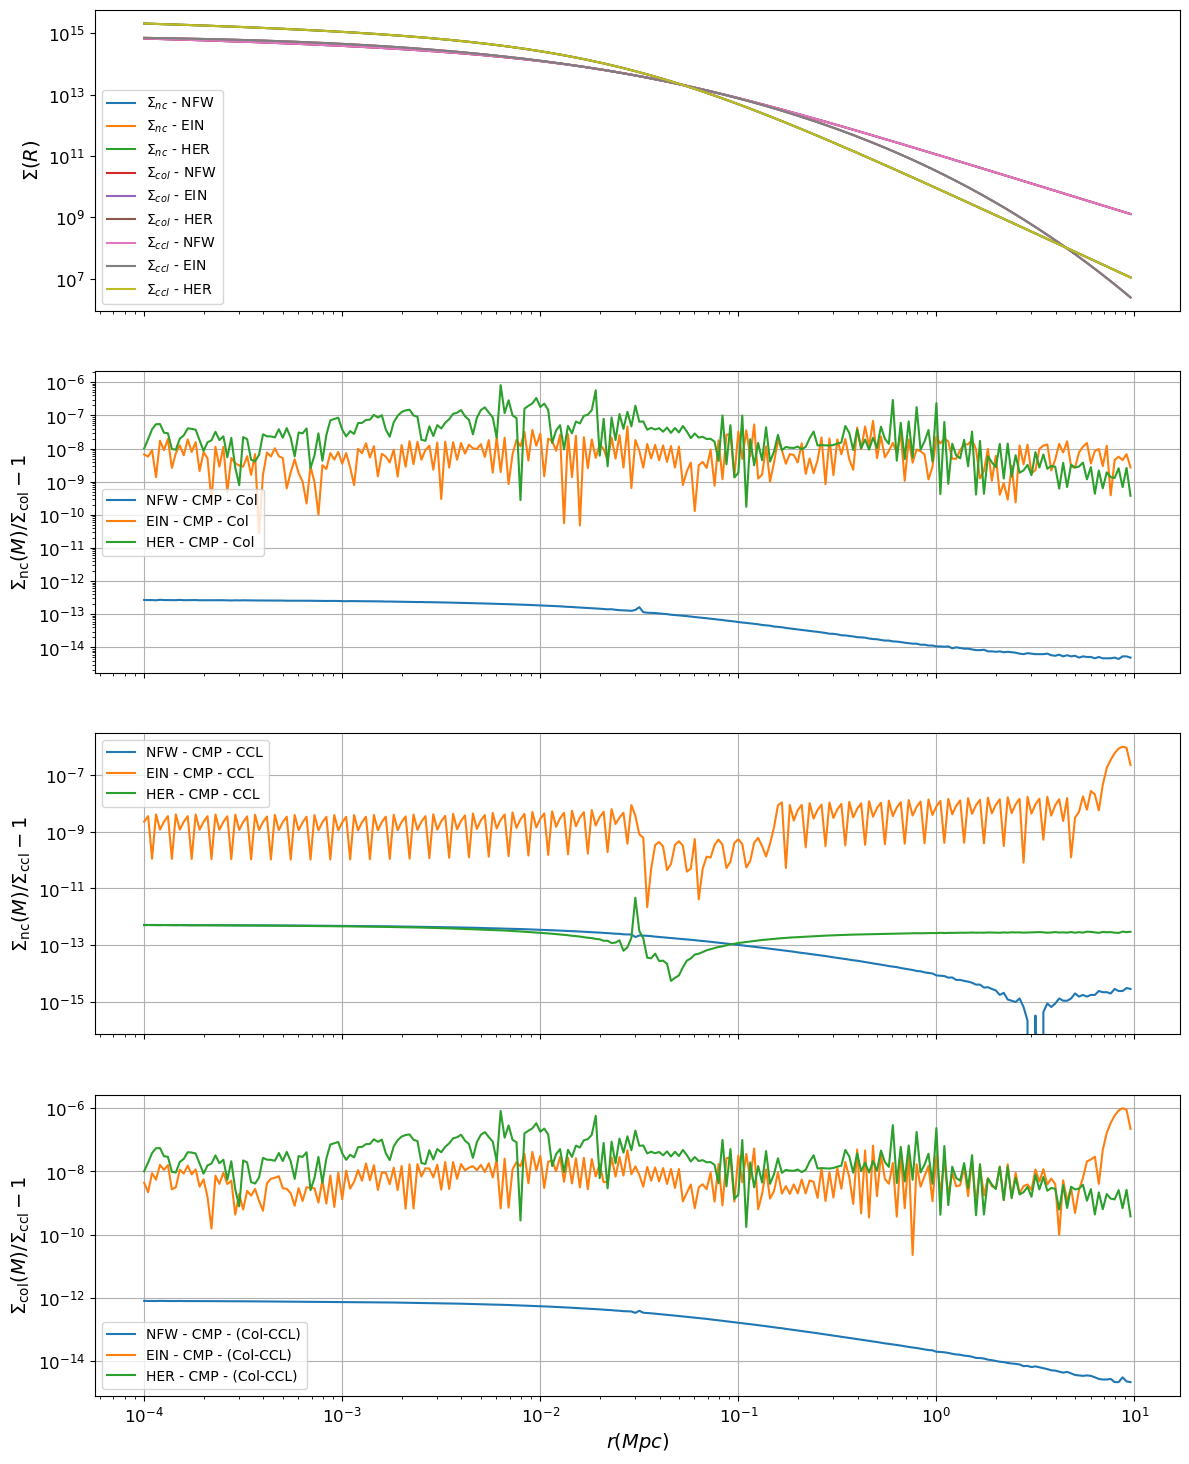

In [12]:
plt.figure()
fig, axs = plt.subplots(4, sharex=True, figsize=(14, 18))

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[3].set_yscale("log")
axs[3].set_xlabel(r"$r (Mpc)$", fontsize=14)
axs[0].set_ylabel(r"$\Sigma(R)$", fontsize=14)
axs[1].set_ylabel(r"$\Sigma_{\mathrm{nc}} (M) / \Sigma_{\mathrm{col}} - 1$", fontsize=14)
axs[2].set_ylabel(r"$\Sigma_{\mathrm{nc}} (M) / \Sigma_{\mathrm{ccl}} - 1$", fontsize=14)
axs[3].set_ylabel(r"$\Sigma_{\mathrm{col}} (M) / \Sigma_{\mathrm{ccl}} - 1$", fontsize=14)
axs[0].plot(r, n, "-", label=r"$\Sigma_{nc}$ - NFW")
axs[0].plot(r, e, "-", label=r"$\Sigma_{nc}$ - EIN")
axs[0].plot(r, h, "-", label=r"$\Sigma_{nc}$ - HER")
axs[0].plot(r, col_Sigma_nfw, "-", label=r"$\Sigma_{col}$ - NFW")
axs[0].plot(r, col_Sigma_ein, "-", label=r"$\Sigma_{col}$ - EIN")
axs[0].plot(r, col_Sigma_her, "-", label=r"$\Sigma_{col}$ - HER")
axs[0].plot(r, ccl_Sigma_nfw, "-", label=r"$\Sigma_{ccl}$ - NFW")
axs[0].plot(r, ccl_Sigma_ein, "-", label=r"$\Sigma_{ccl}$ - EIN")
axs[0].plot(r, ccl_Sigma_her, "-", label=r"$\Sigma_{ccl}$ - HER")

axs[1].plot(r, np.abs(n / col_Sigma_nfw - 1.0), "-", label="NFW - CMP - Col")
axs[1].plot(r, np.abs(e / col_Sigma_ein - 1.0), "-", label="EIN - CMP - Col")
axs[1].plot(r, np.abs(h / col_Sigma_her - 1.0), "-", label="HER - CMP - Col")
axs[2].plot(r, np.abs(n / ccl_Sigma_nfw - 1.0), "-", label="NFW - CMP - CCL")
axs[2].plot(r, np.abs(e / ccl_Sigma_ein - 1.0), "-", label="EIN - CMP - CCL")
axs[2].plot(r, np.abs(h / ccl_Sigma_her - 1.0), "-", label="HER - CMP - CCL")
axs[3].plot(r, np.abs(col_Sigma_nfw / ccl_Sigma_nfw - 1.0), "-", label="NFW - CMP - (Col-CCL)")
axs[3].plot(r, np.abs(col_Sigma_ein / ccl_Sigma_ein - 1.0), "-", label="EIN - CMP - (Col-CCL)")
axs[3].plot(r, np.abs(col_Sigma_her / ccl_Sigma_her - 1.0), "-", label="HER - CMP - (Col-CCL)")

axs[0].legend(loc="best")
axs[1].legend(loc="best")
axs[2].grid()
axs[2].legend(loc="best")
axs[1].grid()
axs[3].legend(loc="best")
axs[3].grid()
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)
axs[3].tick_params(axis='both', which='major', labelsize=12)



plt.show()

Set Density Profile - K11

In [22]:
# CCL
mdef_ccl = ccl.halos.MassDef(Delta="vir", rho_type = "matter")
k11 = ccl.halos.ConcentrationKlypin11(mass_def = mdef_ccl)

mdef_ccl.concentration = k11
ccl_nfw = ccl.halos.HaloProfileNFW(mass_def=mdef_ccl, concentration=k11, truncated=False, projected_analytic=True, cumul2d_analytic=True)
ccl_ein = ccl.halos.HaloProfileEinasto(mass_def=mdef_ccl, concentration=k11, truncated=False, projected_quad=True, alpha = 0.2)
ccl_her = ccl.halos.HaloProfileHernquist(mass_def=mdef_ccl, concentration=k11, truncated=False, projected_analytic=True, cumul2d_analytic=True)

alpha = ccl_ein._get_alpha(ccl_cosmo, M, a)

# Colossus
col_nfw = profile_nfw.NFWProfile(M=M_col, c=col_k11, z=z, mdef="vir")
col_ein = profile_einasto.EinastoProfile(M=M_col, c=col_k11, z=z, mdef="vir", alpha=0.2)
col_her = profile_hernquist.HernquistProfile(M=M_col, c=col_k11, z=z, mdef="vir")

#NC
nfw_k11 = Nc.HaloDensityProfileNFW.new(cmr_Klypin11)
ein_k11 = Nc.HaloDensityProfileEinasto.new(cmr_Klypin11)
her_k11 = Nc.HaloDensityProfileHernquist.new(cmr_Klypin11)
ein_k11.param_set_by_name("alpha", 0.2)

Comparing NFW, Einasto and Hernquist the Surface Mass Density (K11)

In [23]:
# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity(R * cosmo_col.h * 1.0e3) * (cosmo_col.h * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity(R * cosmo_col.h * 1.0e3) * (cosmo_col.h * 1.0e6)
col_Sigma_her = col_her.surfaceDensity(R * cosmo_col.h * 1.0e3) * (cosmo_col.h * 1.0e6)

# NumCosmo
nc_Sigma_nfw = nfw_k11.eval_2d_density(cosmo, R, z)
nc_Sigma_ein = ein_k11.eval_2d_density(cosmo, R, z)
nc_Sigma_her = her_k11.eval_2d_density(cosmo, R, z)

# CCL
ccl_Sigma_nfw = ccl_nfw.projected(ccl_cosmo, R / a, M, a) / a**2
ccl_Sigma_ein = ccl_ein.projected(ccl_cosmo, R / a, M, a) / a**2
ccl_Sigma_her = ccl_her.projected(ccl_cosmo, R / a, M, a) / a**2

In [24]:
cmp_double("NFW", "NumCosmo", "CCL     ", nc_Sigma_nfw, ccl_Sigma_nfw)
cmp_double("EIN", "NumCosmo", "CCL     ", nc_Sigma_ein, ccl_Sigma_ein)
cmp_double("HER", "NumCosmo", "CCL     ", nc_Sigma_her, ccl_Sigma_her)

print("--------------------------------------------------------------------------------")

cmp_double("NFW", "NumCosmo", "COL     ", nc_Sigma_nfw, col_Sigma_nfw)
cmp_double("EIN", "NumCosmo", "COL     ", nc_Sigma_ein, col_Sigma_ein)
cmp_double("HER", "NumCosmo", "COL     ", nc_Sigma_her, col_Sigma_her)

print("--------------------------------------------------------------------------------")

cmp_double("NFW", "COL     ", "CCL     ", col_Sigma_nfw, ccl_Sigma_nfw)
cmp_double("EIN", "COL     ", "CCL     ", col_Sigma_ein, ccl_Sigma_ein)
cmp_double("HER", "COL     ", "CCL     ", col_Sigma_her, ccl_Sigma_her)

NFW: NumCosmo =       10754350.8748106, CCL      =       10754350.8748105, CMP:  2.89e-15
EIN: NumCosmo =     0.0392203679341728, CCL      =     0.0392203664507806, CMP:  3.78e-08
HER: NumCosmo =       8076.40061278434, CCL      =       8076.40061278243, CMP:  2.37e-13
--------------------------------------------------------------------------------
NFW: NumCosmo =       10754350.8748106, COL      =       10754350.8748105, CMP:  3.55e-15
EIN: NumCosmo =     0.0392203679341728, COL      =      0.039220325473895, CMP:  1.08e-06
HER: NumCosmo =       8076.40061278434, COL      =       8076.40060719501, CMP:  6.92e-10
--------------------------------------------------------------------------------
NFW: COL      =       10754350.8748105, CCL      =       10754350.8748105, CMP:  6.66e-16
EIN: COL      =      0.039220325473895, CCL      =     0.0392203664507806, CMP:  1.04e-06
HER: COL      =       8076.40060719501, CCL      =       8076.40061278243, CMP:  6.92e-10


In [25]:
r = 10 ** np.arange(-1, +4, 0.02) * 1.0e-3 

# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity(r * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity(r * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)
col_Sigma_her = col_her.surfaceDensity(r * cosmo.h() * 1.0e3) * (cosmo.h() * 1.0e6)

# NumCosmo
n_k11 = []
e_k11 = []
h_k11 = []
for i in r:
    nc_Sigma_nfw_a = nfw_k11.eval_2d_density(cosmo, i, z)
    nc_Sigma_ein_a = ein_k11.eval_2d_density(cosmo, i, z)
    nc_Sigma_her_a = her_k11.eval_2d_density(cosmo, i, z)
    n_k11.append(nc_Sigma_nfw_a)
    e_k11.append(nc_Sigma_ein_a)
    h_k11.append(nc_Sigma_her_a)

# CCL
ccl_Sigma_nfw = ccl_nfw.projected(ccl_cosmo, r / a, M, a) / a**2
ccl_Sigma_ein = ccl_ein.projected(ccl_cosmo, r / a, M, a) / a**2
ccl_Sigma_her = ccl_her.projected(ccl_cosmo, r / a, M, a) / a**2

<Figure size 640x480 with 0 Axes>

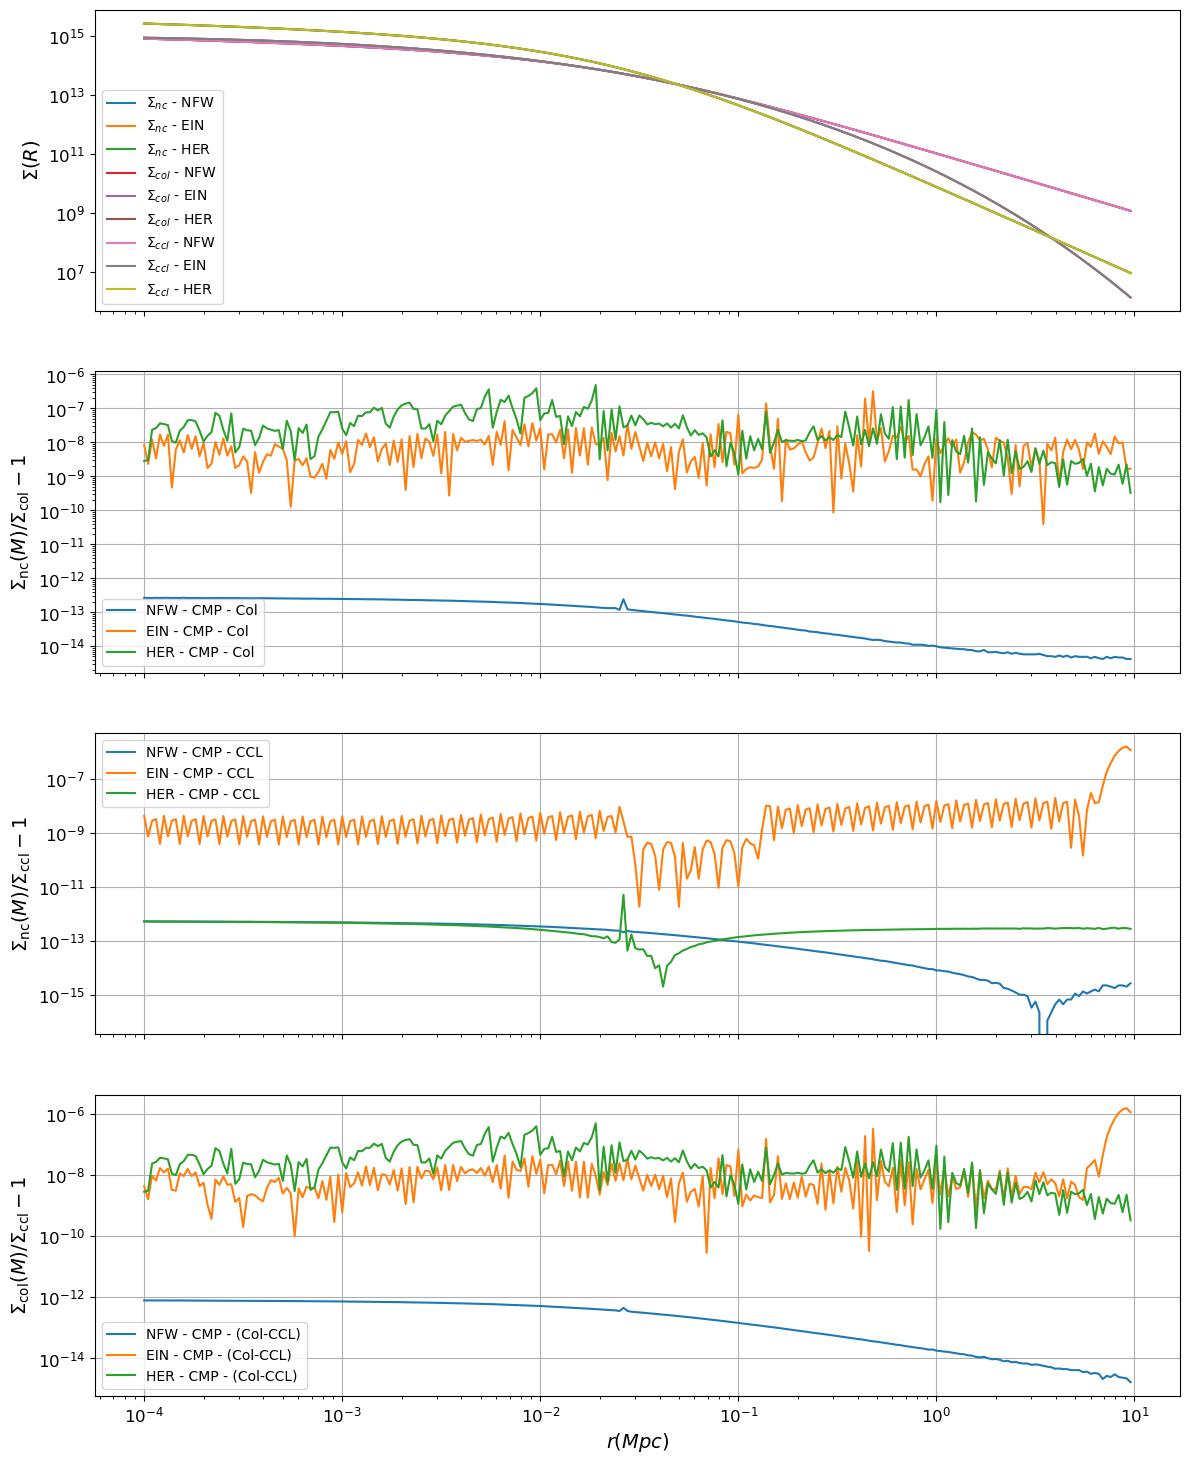

In [26]:
plt.figure()
fig, axs = plt.subplots(4, sharex=True, figsize=(14, 18))

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[3].set_yscale("log")
axs[3].set_xlabel(r"$r (Mpc)$", fontsize=14)
axs[0].set_ylabel(r"$\Sigma(R)$", fontsize=14)
axs[1].set_ylabel(r"$\Sigma_{\mathrm{nc}} (M) / \Sigma_{\mathrm{col}} - 1$", fontsize=14)
axs[2].set_ylabel(r"$\Sigma_{\mathrm{nc}} (M) / \Sigma_{\mathrm{ccl}} - 1$", fontsize=14)
axs[3].set_ylabel(r"$\Sigma_{\mathrm{col}} (M) / \Sigma_{\mathrm{ccl}} - 1$", fontsize=14)
axs[0].plot(r, n_k11, "-", label=r"$\Sigma_{nc}$ - NFW")
axs[0].plot(r, e_k11, "-", label=r"$\Sigma_{nc}$ - EIN")
axs[0].plot(r, h_k11, "-", label=r"$\Sigma_{nc}$ - HER")
axs[0].plot(r, col_Sigma_nfw, "-", label=r"$\Sigma_{col}$ - NFW")
axs[0].plot(r, col_Sigma_ein, "-", label=r"$\Sigma_{col}$ - EIN")
axs[0].plot(r, col_Sigma_her, "-", label=r"$\Sigma_{col}$ - HER")
axs[0].plot(r, ccl_Sigma_nfw, "-", label=r"$\Sigma_{ccl}$ - NFW")
axs[0].plot(r, ccl_Sigma_ein, "-", label=r"$\Sigma_{ccl}$ - EIN")
axs[0].plot(r, ccl_Sigma_her, "-", label=r"$\Sigma_{ccl}$ - HER")

axs[1].plot(r, np.abs(n_k11 / col_Sigma_nfw - 1.0), "-", label="NFW - CMP - Col")
axs[1].plot(r, np.abs(e_k11 / col_Sigma_ein - 1.0), "-", label="EIN - CMP - Col")
axs[1].plot(r, np.abs(h_k11 / col_Sigma_her - 1.0), "-", label="HER - CMP - Col")
axs[2].plot(r, np.abs(n_k11 / ccl_Sigma_nfw - 1.0), "-", label="NFW - CMP - CCL")
axs[2].plot(r, np.abs(e_k11 / ccl_Sigma_ein - 1.0), "-", label="EIN - CMP - CCL")
axs[2].plot(r, np.abs(h_k11 / ccl_Sigma_her - 1.0), "-", label="HER - CMP - CCL")
axs[3].plot(r, np.abs(col_Sigma_nfw / ccl_Sigma_nfw - 1.0), "-", label="NFW - CMP - (Col-CCL)")
axs[3].plot(r, np.abs(col_Sigma_ein / ccl_Sigma_ein - 1.0), "-", label="EIN - CMP - (Col-CCL)")
axs[3].plot(r, np.abs(col_Sigma_her / ccl_Sigma_her - 1.0), "-", label="HER - CMP - (Col-CCL)")

axs[0].legend(loc="best")
axs[1].legend(loc="best")
axs[2].grid()
axs[2].legend(loc="best")
axs[1].grid()
axs[3].legend(loc="best")
axs[3].grid()
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)
axs[3].tick_params(axis='both', which='major', labelsize=12)

plt.show()

Comparing surface mass density (D08 and K11)

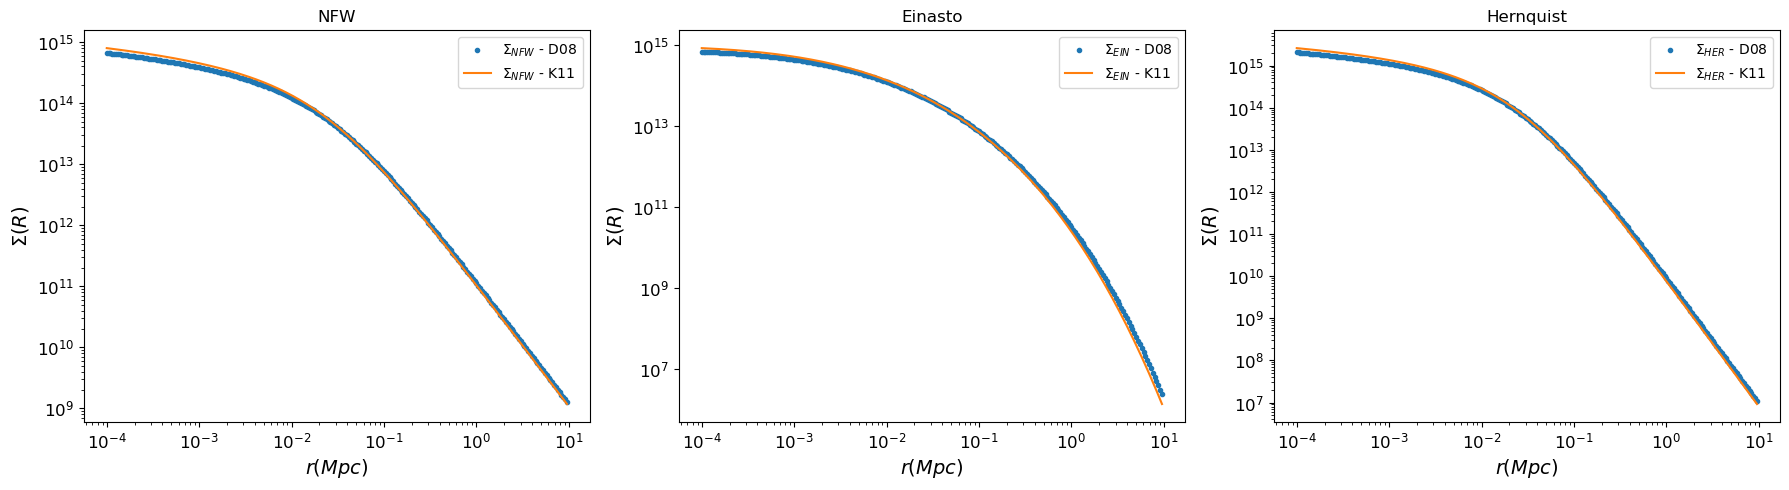

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))


axs[0].set_title("NFW")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_ylabel(r"$\Sigma(R)$", fontsize=14)
axs[0].set_xlabel(r"$r(Mpc)$", fontsize=14)
axs[0].plot(r, n, ".", label=r"$\Sigma_{NFW}$ - D08")
axs[0].plot(r, n_k11, "-", label=r"$\Sigma_{NFW}$ - K11")
axs[0].legend(loc="best")

axs[1].set_title("Einasto")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylabel(r"$\Sigma(R)$", fontsize=14)
axs[1].set_xlabel(r"$r(Mpc)$", fontsize=14)
axs[1].plot(r, e, ".", label=r"$\Sigma_{EIN}$ - D08")
axs[1].plot(r, e_k11, "-", label=r"$\Sigma_{EIN}$ - K11")
axs[1].legend(loc="best")

axs[2].set_title("Hernquist")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_ylabel(r"$\Sigma(R)$", fontsize=14)
axs[2].set_xlabel(r"$r(Mpc)$", fontsize=14)
axs[2].plot(r, h, ".", label=r"$\Sigma_{HER}$ - D08")
axs[2].plot(r, h_k11, "-", label=r"$\Sigma_{HER}$ - K11")
axs[2].legend(loc="best")

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

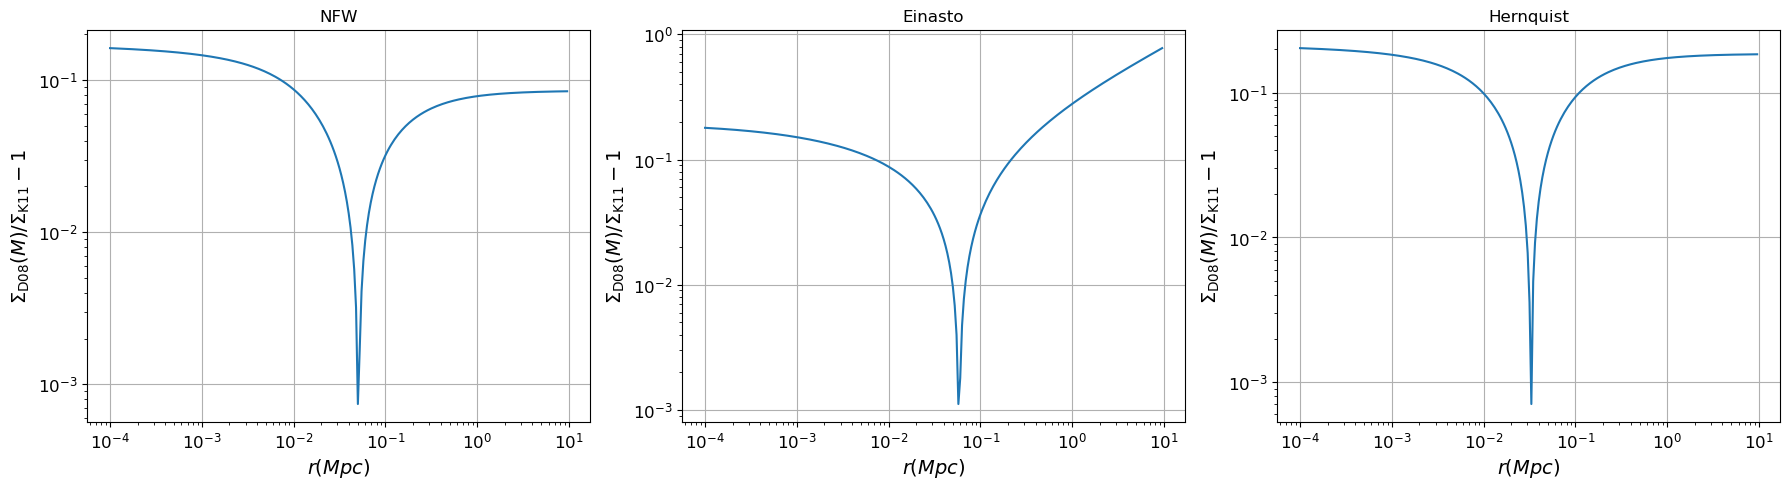

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
n = np.array(n)
n_k11 = np.array(n_k11)
e = np.array(e)
e_k11 = np.array(e_k11)
h = np.array(h)
h_k11 = np.array(h_k11)
r = np.array(r)

axs[0].set_title("NFW")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_ylabel(r"$\Sigma_{\mathrm{D08}} (M) / \Sigma_{\mathrm{K11}} - 1$", fontsize=14)
axs[0].set_xlabel(r"$r(Mpc)$", fontsize=14)
axs[0].plot(r, np.abs(n / n_k11 - 1.0), "-")

axs[1].set_title("Einasto")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_ylabel(r"$\Sigma_{\mathrm{D08}} (M) / \Sigma_{\mathrm{K11}} - 1$", fontsize=14)
axs[1].set_xlabel(r"$r(Mpc)$", fontsize=14)
axs[1].plot(r, np.abs(e / e_k11 - 1.0), "-")

axs[2].set_title("Hernquist")
axs[2].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_ylabel(r"$\Sigma_{\mathrm{D08}} (M) / \Sigma_{\mathrm{K11}} - 1$", fontsize=14)
axs[2].set_xlabel(r"$r(Mpc)$", fontsize=14)
axs[2].plot(r, np.abs(h / h_k11 - 1.0), "-")

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)

axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.tight_layout()
plt.show()